In [321]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

import sympy as sp
import numpy as np

In [322]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)
n_init, order, r = get_processed_and_shifted_recurrence(laplace2d)

In [323]:
def scale_recurrence(r):
    #We want to subsitute s(i) r^i_{ct} = g(i)
    g = sp.Function("g")
    s = sp.Function("s")
    n = sp.symbols("n")
    rct = sp.symbols("r_{ct}")

    r_new = r*rct**n
    for i in range(order):
        r_new = r_new.subs(s(n-i),g(n-i)/(rct**(n-i)))

    return r_new

In [324]:
r_new = scale_recurrence(r)

In [325]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs
derivs = compute_derivatives(15)

In [326]:
max_abs = .0000001
x_coord = np.random.rand()*max_abs  # noqa: NPY002
y_coord = np.random.rand()*max_abs
var = _make_sympy_vec("x", 2)
coord_dict = {var[0]: x_coord, var[1]: y_coord}

In [327]:
def evaluate_recurrence(coord_dict, rct_val, recur, p):
    subs_dict = {}
    subs_dict[g(0)] = derivs[0].subs(coord_dict).subs(rct, rct_val)
    subs_dict[g(1)] = derivs[1].subs(coord_dict).subs(rct, rct_val) * rct_val
    for i in range(2, p):
        subs_dict[g(i)] = recur.subs(n, i).subs(subs_dict).subs(coord_dict).subs(rct, rct_val)
    return np.array(list(subs_dict.values()))

In [328]:
def evaluate_true(coord_dict, rct_val, p):
    retMe = []
    for i in range(p):
        retMe.append(derivs[i].subs(coord_dict).subs(rct, rct_val)*rct_val**i)
    return np.array(retMe)

In [401]:
def compute_error(pw):
    x_coord = -10**(-pw) * 1
    y_coord = 1
    coord_dict = {var[0]: x_coord, var[1]: y_coord}

    exp = evaluate_recurrence(coord_dict, np.sqrt(x_coord**2 + y_coord**2), r_new, 14)
    true = evaluate_true(coord_dict, np.sqrt(x_coord**2 + y_coord**2), 14)
    return np.abs(exp-true)/np.abs(true)

In [402]:
import matplotlib.pyplot as plt

In [403]:
compute_error(5)

array([0, 0, 1.11022302484720e-16, 2.25875452642557e-16,
       1.48029736735111e-16, 2.42222987653352e-7, 7.26668965361568e-7,
       692.065680462667, 3460.32841068733, 2883607003840.57,
       20185249101011.9, 1.46801811218522e+22, 1.32121630784017e+23,
       8.46933527026372e+31], dtype=object)

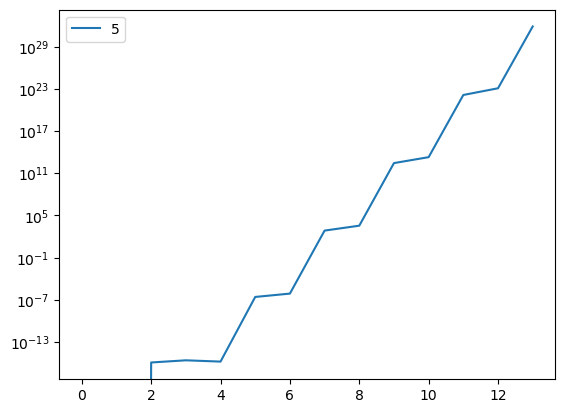

In [409]:
x_plot = [i for i in range(len(compute_error(0)))]
for i in range(5,6):
    plt.semilogy(x_plot, compute_error(i),label=str(i))
plt.legend()
plt.show()